# Foundation of Data Science Project 2020/2021

In our project we are going to predict the severity of an accident based on a set of features (weather, road features, time) about some accidents in US.

# Required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


import plotly.graph_objects as go
from nltk.corpus import stopwords

# Dataset import

In the first place we are going to import the dataset using pandas.

In [2]:
df = pd.read_csv("../input/us-accidents/US_Accidents_June20.csv")
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


# Exploratory Data Analysis (EDA)

In this first part of this notebook we are going to do an EDA of the dataset.

## Number of Accidents per State

With the following code we are going to create a map of each state of the US with a color based on the number of accidents present in the dataset for that state.

In [3]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

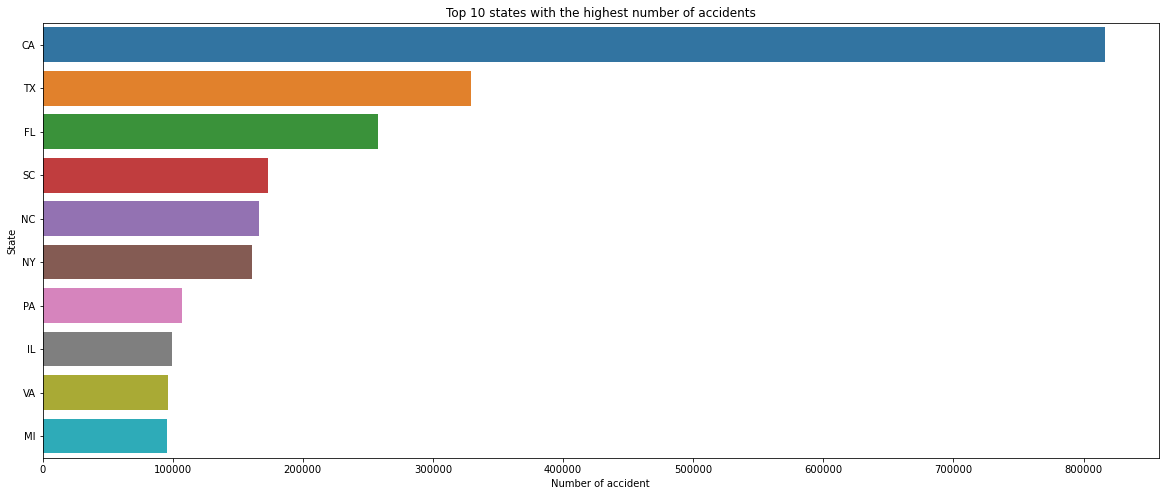

In [4]:
plt.figure(figsize=(20, 8))
plt.title("Top 10 states with the highest number of accidents")
sns.barplot(state_counts[:10].values, state_counts[:10].index, orient="h")
plt.xlabel("Number of accident")
plt.ylabel("State")
plt.show()

As we can see from the map and the plot above California is the state with the highest number of accidents, then we have Texas and Florida.

## Most frequent words in the description of an accident with severity 4

We are going to compute the most frequent words in the description column of the accidents with a value of severity equal to 4, using some stopwords from the english language.

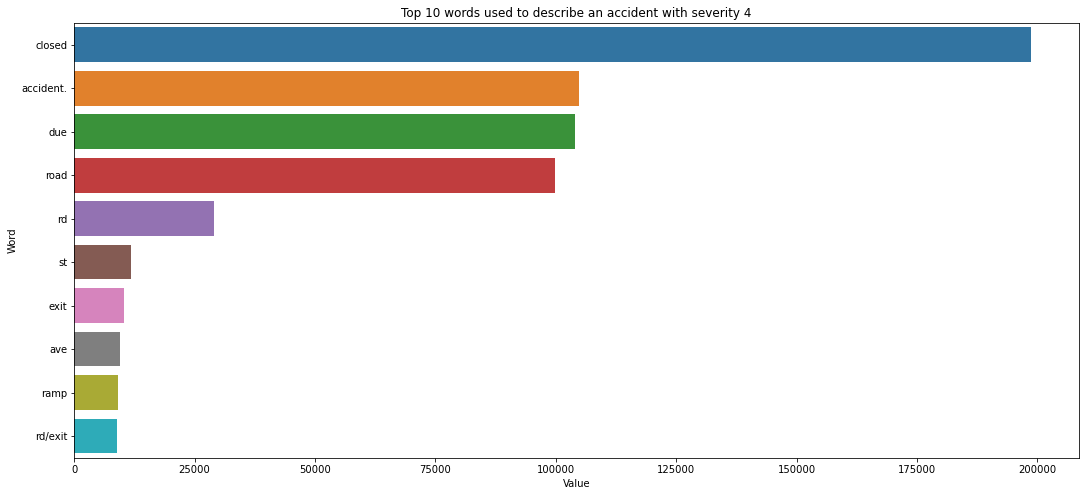

In [5]:
stop = stopwords.words("english") + ["-"]

df_s4_desc = df[df["Severity"] == 4]["Description"]
# Split the description
df_words = df_s4_desc.str.lower().str.split(expand=True).stack()

# If the word is not in the stopwords list
counts = df_words[~df_words.isin(stop)].value_counts()[:10]

plt.figure(figsize=(18, 8))
plt.title("Top 10 words used to describe an accident with severity 4")
sns.barplot(counts.values, counts.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Word")
plt.show()

We can see that the most used word in the description is *closed*. Subsequent words are *accident*, *due* and *road*.

## Most frequent road features

Now we are going to analyze which are the most frequent road features in accidents.

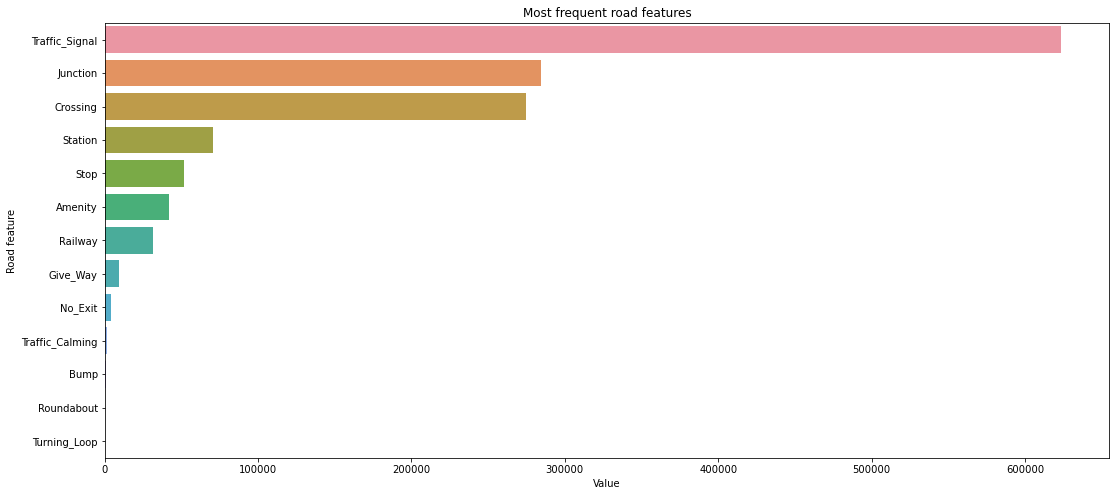

In [6]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
data = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Most frequent road features")
sns.barplot(data.values, data.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Road feature")
plt.show()

As we can see, most of the accidents occured near a traffic signal, expecially where a junction or a crossing was present. 

The fourth most common road feature, instead, was the presence of a nearby station, probably because of the high presence of vehicles.

## Medium distance by severity

Let's now analyze the medium distance of an accident based on its severity.

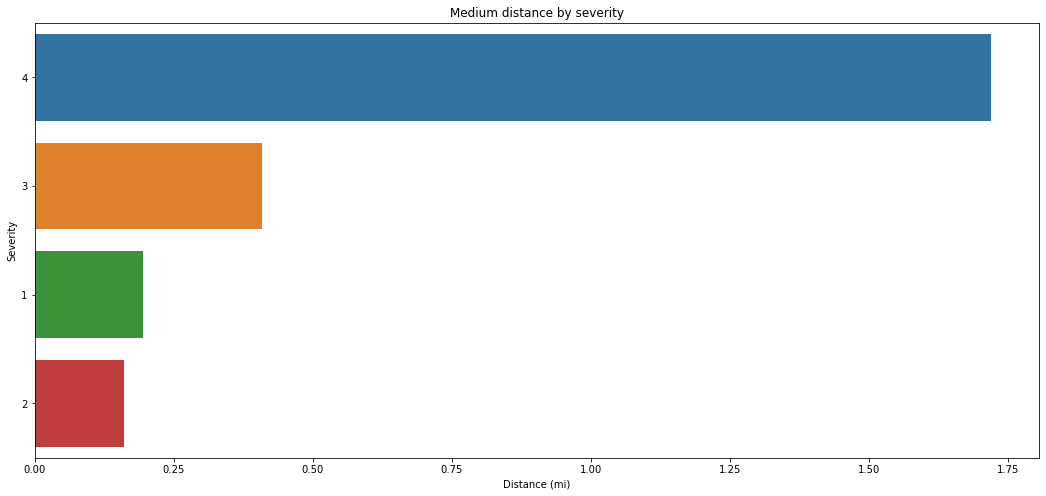

In [7]:
severity_distance = df.groupby("Severity").mean()["Distance(mi)"].sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Medium distance by severity")
sns.barplot(severity_distance.values, severity_distance.index, orient="h", order=severity_distance.index)
plt.xlabel("Distance (mi)")
plt.show()

In this graph we can see that the distance of the accident is more or less proportional to the severity, and in fact accidents with severity 4 have the longest distance.

## Weather condition histogram

With the following code we can plot the histogram of the weather condition column.

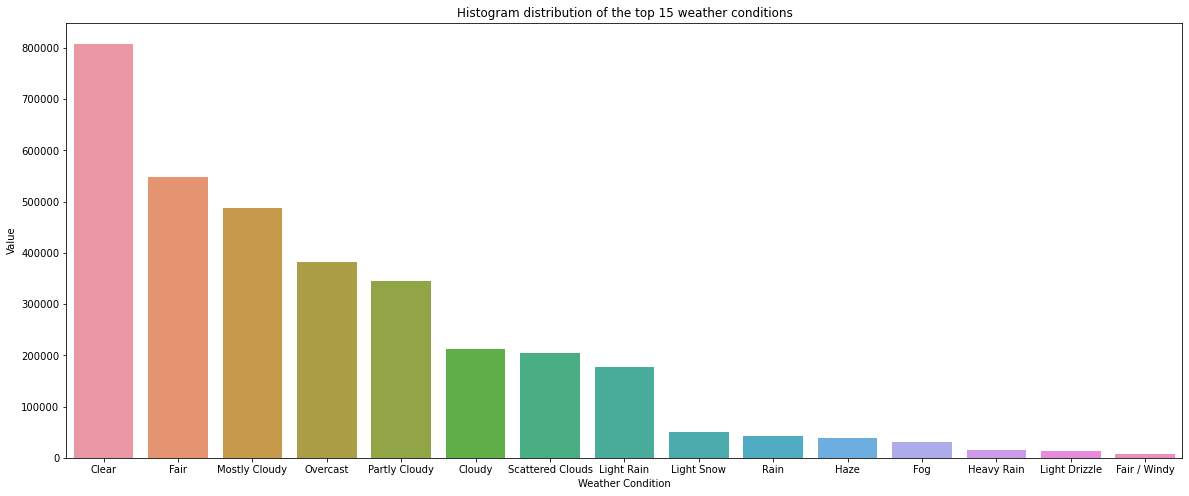

In [8]:
counts = df["Weather_Condition"].value_counts()[:15]
plt.figure(figsize=(20, 8))
plt.title("Histogram distribution of the top 15 weather conditions")
sns.barplot(counts.index, counts.values)
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

In most frequent cases the weather condition is clear.

## Number of accidents for weekday

Here is a plot of the number of accidents appened in each weekday.

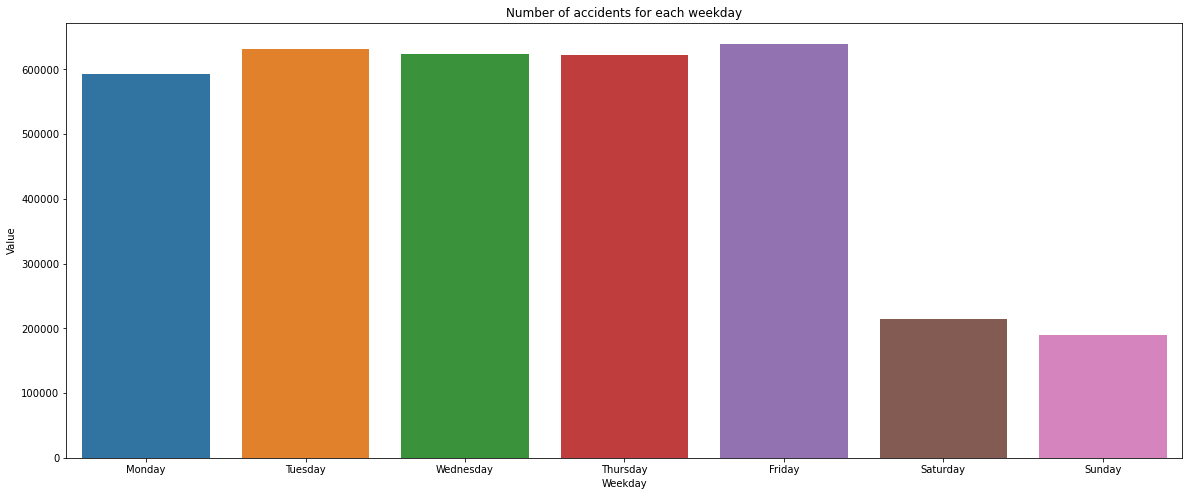

In [9]:
counts = pd.to_datetime(df['Start_Time']).dt.day_name().value_counts()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(20, 8))
plt.title("Number of accidents for each weekday")
sns.barplot(counts.index, counts.values, order=weekdays)
plt.xlabel("Weekday")
plt.ylabel("Value")
plt.show()

As we can see from the plot above, the days with the most accidents are working days, while in the weekend we have a frequency of at least 2/3 less. This may be due to the fact that during the weekend there are fewer cars on the road.

# Data preprocessing

In this phase we are going to process the dataset in order to make it usable for the machine learning models.

In [10]:
X = df
X.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


## Feature addition

We decided to decompose the Start_Time feature in year, month, day, weekday, hour and minute, in order to feed them to the models.

In [11]:
# Cast Start_Time to datetime
X["Start_Time"] = pd.to_datetime(X["Start_Time"])

# Extract year, month, weekday and day
X["Year"] = X["Start_Time"].dt.year
X["Month"] = X["Start_Time"].dt.month
X["Weekday"] = X["Start_Time"].dt.weekday
X["Day"] = X["Start_Time"].dt.day

# Extract hour and minute
X["Hour"] = X["Start_Time"].dt.hour
X["Minute"] = X["Start_Time"].dt.minute

X.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,Night,Night,Night,Night,2016,2,0,8,5,46
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,Night,Night,Night,Day,2016,2,0,8,6,7
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,Night,Night,Day,Day,2016,2,0,8,6,49
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,Night,Day,Day,Day,2016,2,0,8,7,23
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,Day,Day,Day,Day,2016,2,0,8,7,39


## Check correlation between features


In the next block is presented the correlation matrix between all the possible features, in the form of an heatmap. 

With that we can observe the correlation between the different features of the dataset, in order to check if some features are highly correlated and remove one of them.

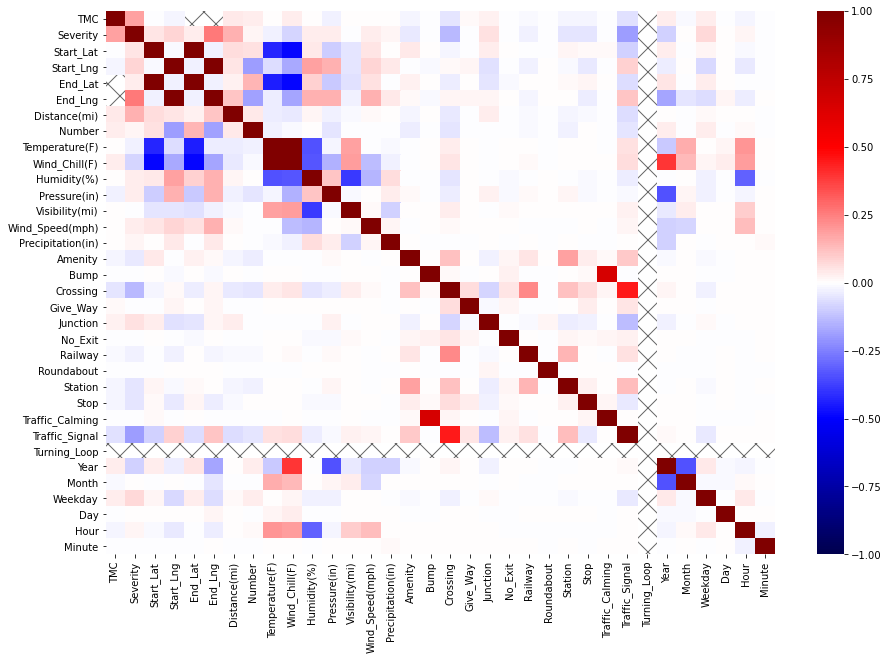

In [12]:
corr_matrix = X.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

From the matrix we can see that the start and end GPS coordinates of the accidents are highly correlated. 

In fact, from the medium distance shown before, the end of the accident is usually close to the start, so we can consider just one of them for the machine learning models.

Moreover, the wind chill (temperature) is directly proportional to the temperature, so we can also drop one of them.

We can also see that the presence of a traffic signal is slightly correlated to the severity of an accident meaning that maybe traffic lights can help the traffic flow when an accident occurs.

From the matrix we can also note that we couldn't compute the covariance with Turning_Loop, and that's because it's always False.

## Feature selection

Here is the process of feature selection, in order to select the best features from which our models can learn.

From the observations made with the correlation matrix, we are going to drop the following features:
- End_Lat and End_Lng
- Wind Chill

Moreover, we are going to drop the following features:
- ID, Source: since they don't carry any information for the severity
- TMC: because it could already contains information about the accident severity
- Start_Time: because it was decomposed by the time features added before (day, month, weekday)
- End_Time: beause we cannot know in advance when the traffic flow will become regular again
- Description: most description only report the name of the road of the accident, and so we decided to omit this feature for semplicity
- Number, Street, County, State, Zipcode, Country: because we just focus on the City where the accident happened
- Timezone, Airport_Code, Weather_Timestamp: because they are not useful for our task
- Turning_Loop: since it's always False
- Sunrise_Sunset, Nautical_Twilight, Astronomical_Twilight: because they are redundant

In [13]:
features_to_drop = ["ID", "Source", "TMC", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Number", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
X = X.drop(features_to_drop, axis=1)
X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,3,39.865147,-84.058723,0.01,R,Dayton,36.9,91.0,29.68,10.0,...,False,False,False,Night,2016,2,0,8,5,46
1,2,39.928059,-82.831184,0.01,L,Reynoldsburg,37.9,100.0,29.65,10.0,...,False,False,False,Night,2016,2,0,8,6,7
2,2,39.063148,-84.032608,0.01,R,Williamsburg,36.0,100.0,29.67,10.0,...,False,False,True,Night,2016,2,0,8,6,49
3,3,39.747753,-84.205582,0.01,R,Dayton,35.1,96.0,29.64,9.0,...,False,False,False,Day,2016,2,0,8,7,23
4,2,39.627781,-84.188354,0.01,R,Dayton,36.0,89.0,29.65,6.0,...,False,False,True,Day,2016,2,0,8,7,39


## Drop duplicates

In this section we are going to check if there are some duplicates in the dataset.

In [14]:
print("Number of rows:", len(X.index))
X.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(X.index))

Number of rows: 3513617
Number of rows after drop of duplicates: 3475495


## Handle erroneous and missing values

Here we are going to clean the dataset from erroneous or missing values.

Let's start looking to the Side column:

In [15]:
X["Side"].value_counts()

R    2850946
L     624548
           1
Name: Side, dtype: int64

We can see that there is one record without side, so we can drop it.

In [16]:
X = X[X["Side"] != " "]
X["Side"].value_counts()

R    2850946
L     624548
Name: Side, dtype: int64

Let's instead analyze Pressure and Visibility:

In [17]:
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,3420336.00,3400806.00
mean,29.75,9.12
std,0.82,2.89
min,0.00,0.00
25%,29.74,10.00
50%,29.95,10.00
75%,30.09,10.00
max,57.74,140.00


 We can see that the minimum value is 0, meaning that some records are missing them and replaced them by putting zeros.
 For this reason, we are going to drop the records with missing values for these two columns.

In [18]:
X = X[X["Pressure(in)"] != 0]
X = X[X["Visibility(mi)"] != 0]
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,3418896.00,3399364.00
mean,29.75,9.13
std,0.82,2.88
min,0.02,0.06
25%,29.74,10.00
50%,29.95,10.00
75%,30.09,10.00
max,57.74,140.00


If we analyze the weather conditions, we can see that there are lots of them, so it's better to reduce the number of unique conditions.

In [19]:
unique_weather = X["Weather_Condition"].unique()

print(len(unique_weather))
print(unique_weather)

128
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light Fog' 'Sand'
 'Sn

To do so, we are going to replace them with a more generic description:

In [20]:
X.loc[X["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
X.loc[X["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
X.loc[X["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
X.loc[X["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
X.loc[X["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
X.loc[X["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
X.loc[X["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
X.loc[X["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
X.loc[X["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
X.loc[X["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
X.loc[X["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(X["Weather_Condition"].unique())

['Rain' 'Cloudy' 'Snow' 'Fog' 'Clear' nan 'Smoke' 'Thunderstorm' 'Sand'
 'Windy' 'Hail' 'Tornado']


Let's check also the Wind_Direction field:

In [21]:
X["Wind_Direction"].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

As we can see, we can group the values like we did with Weather_Condition:

In [22]:
X.loc[X["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
X.loc[X["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
X.loc[X["Wind_Direction"] == "East", "Wind_Direction"] = "E"
X.loc[X["Wind_Direction"] == "North", "Wind_Direction"] = "N"
X.loc[X["Wind_Direction"] == "South", "Wind_Direction"] = "S"
X.loc[X["Wind_Direction"] == "West", "Wind_Direction"] = "W"

X["Wind_Direction"] = X["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

X["Wind_Direction"].unique()

array(['Calm', 'SW', 'NW', 'W', 'NE', 'S', 'N', 'Variable', 'SE', 'E',
       nan], dtype=object)

Next, let's analyze the missing values:

In [23]:
X.isna().sum()

Severity                   0
Start_Lat                  0
Start_Lng                  0
Distance(mi)               0
Side                       0
City                     109
Temperature(F)         64889
Humidity(%)            68783
Pressure(in)           55155
Visibility(mi)         74687
Wind_Direction         57666
Wind_Speed(mph)       451503
Precipitation(in)    2014303
Weather_Condition      75361
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Civil_Twilight           112
Year                       0
Month                      0
Weekday                    0
Day                        0
Hour                       0
Minute                     0
dtype: int64

Since a lot of records do not have informations about Precipitation, we are going to drop the feature.

For numerical features we are going to fill the missing features with the mean, while for categorical features like City, Wind_Direction, Weather_Condition and Civil_Twilight, we are going to delete the records with missing informations.

In [24]:
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
X[features_to_fill] = X[features_to_fill].fillna(X[features_to_fill].mean())

X.dropna(inplace=True)

X.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Side                 0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

## Check features variance

In this section we are going to check the variance for each feature in order to remove features with a very low variance beacuse they can't help to discriminate instances.

In [25]:
X.describe().round(2)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Month,Weekday,Day,Hour,Minute
count,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00,3389063.00
mean,2.34,36.51,-95.87,0.28,61.96,65.16,29.75,9.13,8.21,0.02,2018.13,6.54,2.42,15.68,12.15,30.05
std,0.55,4.90,17.34,1.54,18.58,22.68,0.82,2.88,4.96,0.12,1.24,3.49,1.73,8.70,5.12,17.28
min,1.00,24.56,-124.62,0.00,-89.00,1.00,0.02,0.06,0.00,0.00,2016.00,1.00,0.00,1.00,0.00,0.00
25%,2.00,33.61,-117.46,0.00,50.00,49.00,29.74,10.00,5.00,0.00,2017.00,3.00,1.00,8.00,8.00,15.00
50%,2.00,35.84,-91.06,0.00,64.00,67.00,29.95,10.00,8.10,0.02,2018.00,6.00,2.00,16.00,12.00,30.00
75%,3.00,40.32,-81.00,0.01,75.90,84.00,30.09,10.00,10.40,0.02,2019.00,10.00,4.00,23.00,16.00,45.00
max,4.00,49.00,-67.11,333.63,170.60,100.00,57.74,140.00,984.00,25.00,2020.00,12.00,6.00,31.00,23.00,59.00


Even though Precipitation and Pressure have a small variance, there is no need to drop them since they usually have small increments.

## Handle unbalanced data

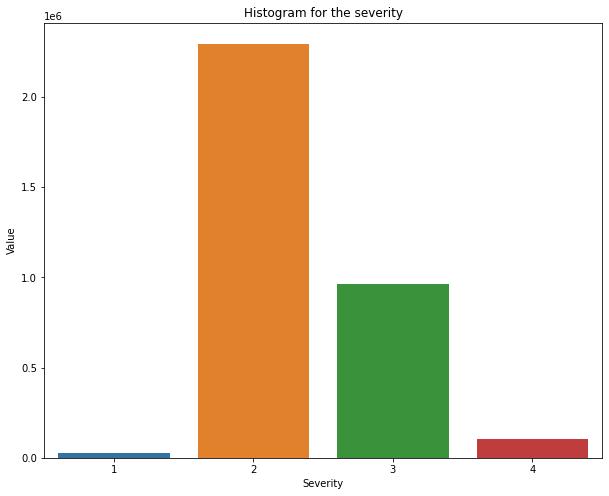

In [26]:
severity_counts = X["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

The severity attribute as we can see from the previous plot is highly unbalanced, the number of accident with the severity 1 is very small instead the number of accident with severity 2 is much higher.

So, in order to balance the data we are going to undersample all the categories to the number of records of the minority category, in this case the severity 1.
We thought this was a good choice since this leaves us with a good amount of records for each category, which is ~25k records

In [27]:
size = len(X[X["Severity"]==1].index)
df = pd.DataFrame()
for i in range(1,5):
    S = X[X["Severity"]==i]
    df = df.append(S.iloc[np.random.choice(np.arange(len(S)), size)])   
X = df

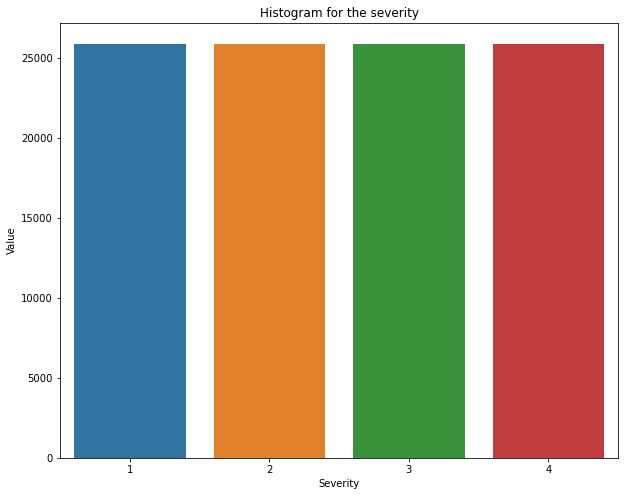

In [28]:
severity_counts = X["Severity"].value_counts()
plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

## Feature scaling

In this section we are going to scale and normalize the features.

To improve the performance of our models, we normalized the values of the continuous features.

In [29]:
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Start_Lng','Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
X[features] = scaler.fit_transform(X[features])
X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
2716717,1,0.371324,0.218953,0.0,L,Phoenix,0.872549,0.091837,0.903079,0.09946,...,False,False,True,Day,1.0,0.363636,1.000000,0.766667,0.652174,0.898305
2840178,1,0.458565,0.809338,0.0,R,Knightdale,0.769608,0.877551,0.951053,0.09946,...,False,False,False,Night,1.0,0.454545,0.833333,0.633333,1.000000,0.084746
2772576,1,0.317967,0.236255,0.0,R,Tucson,0.877451,0.122449,0.870340,0.09946,...,False,False,True,Day,1.0,0.363636,1.000000,0.533333,0.565217,0.152542
2761006,1,0.370074,0.215321,0.0,R,Peoria,0.897059,0.112245,0.919935,0.09946,...,False,False,True,Day,1.0,0.363636,0.000000,0.333333,0.608696,0.355932
2819317,1,0.364742,0.215316,0.0,R,Phoenix,0.818627,0.132653,0.921556,0.09946,...,False,False,True,Night,1.0,0.454545,0.500000,0.333333,0.000000,0.152542


## Feature encoding

Finally, in this section we are going to encode the categorical features.

In [30]:
categorical_features = set(["Side", "City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

for cat in categorical_features:
    X[cat] = X[cat].astype("category")

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103508 entries, 2716717 to 3203336
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Severity           103508 non-null  int64   
 1   Start_Lat          103508 non-null  float64 
 2   Start_Lng          103508 non-null  float64 
 3   Distance(mi)       103508 non-null  float64 
 4   Side               103508 non-null  category
 5   City               103508 non-null  category
 6   Temperature(F)     103508 non-null  float64 
 7   Humidity(%)        103508 non-null  float64 
 8   Pressure(in)       103508 non-null  float64 
 9   Visibility(mi)     103508 non-null  float64 
 10  Wind_Direction     103508 non-null  category
 11  Wind_Speed(mph)    103508 non-null  float64 
 12  Precipitation(in)  103508 non-null  float64 
 13  Weather_Condition  103508 non-null  category
 14  Amenity            103508 non-null  bool    
 15  Bump               103508 n

First of all, we show the number of unique classes for each categorical feature.

In [31]:
print("Unique classes for each categorical feature:")
for cat in categorical_features:
    print("{:15s}".format(cat), "\t", len(X[cat].unique()))

Unique classes for each categorical feature:
City            	 6453
Side            	 2
Wind_Direction  	 10
Civil_Twilight  	 2
Weather_Condition 	 10


Let's first encode the boolean values in a numerical form.

In [32]:
X = X.replace([True, False], [1, 0])

X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
2716717,1,0.371324,0.218953,0.0,L,Phoenix,0.872549,0.091837,0.903079,0.09946,...,0,0,1,Day,1.0,0.363636,1.000000,0.766667,0.652174,0.898305
2840178,1,0.458565,0.809338,0.0,R,Knightdale,0.769608,0.877551,0.951053,0.09946,...,0,0,0,Night,1.0,0.454545,0.833333,0.633333,1.000000,0.084746
2772576,1,0.317967,0.236255,0.0,R,Tucson,0.877451,0.122449,0.870340,0.09946,...,0,0,1,Day,1.0,0.363636,1.000000,0.533333,0.565217,0.152542
2761006,1,0.370074,0.215321,0.0,R,Peoria,0.897059,0.112245,0.919935,0.09946,...,0,0,1,Day,1.0,0.363636,0.000000,0.333333,0.608696,0.355932
2819317,1,0.364742,0.215316,0.0,R,Phoenix,0.818627,0.132653,0.921556,0.09946,...,0,0,1,Night,1.0,0.454545,0.500000,0.333333,0.000000,0.152542


Now we can encode the categorical features using the method `get_dummies()` which converts the features with the one-hot encoding.

In [33]:
# Remove city because it will be encoded later
onehot_cols = categorical_features - set(["City"])

X = pd.get_dummies(X, columns=onehot_cols, drop_first=True)

X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Side_R,Weather_Condition_Cloudy,Weather_Condition_Fog,Weather_Condition_Hail,Weather_Condition_Rain,Weather_Condition_Sand,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_Thunderstorm,Weather_Condition_Windy
2716717,1,0.371324,0.218953,0.0,Phoenix,0.872549,0.091837,0.903079,0.09946,0.014837,...,0,0,0,0,0,0,0,0,0,0
2840178,1,0.458565,0.809338,0.0,Knightdale,0.769608,0.877551,0.951053,0.09946,0.000000,...,1,1,0,0,0,0,0,0,0,0
2772576,1,0.317967,0.236255,0.0,Tucson,0.877451,0.122449,0.870340,0.09946,0.014837,...,1,0,0,0,0,0,0,0,0,0
2761006,1,0.370074,0.215321,0.0,Peoria,0.897059,0.112245,0.919935,0.09946,0.019076,...,1,0,0,0,0,0,0,0,0,0
2819317,1,0.364742,0.215316,0.0,Phoenix,0.818627,0.132653,0.921556,0.09946,0.006359,...,1,0,0,0,0,0,0,0,0,0


Now, remains only to encode the *City* feature. In order to, reduce the usage of memory and the number of features we used the `BinaryEncoder` included in the library category_encoders.

In [34]:
binary_encoder = ce.binary.BinaryEncoder()

city_binary_enc = binary_encoder.fit_transform(X["City"])
city_binary_enc

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
2716717,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2840178,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2772576,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2761006,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2819317,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457325,0,0,0,1,1,0,0,0,1,1,1,0,1,0
2969492,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2710844,0,1,1,0,0,1,0,0,1,1,0,1,0,1
2705429,0,0,0,1,0,0,1,0,1,1,0,1,0,1


Finally, we can merge the two dataframes and obtain the final dataframe X with the categorical features encoded.

In [35]:
X = pd.concat([X, city_binary_enc], axis=1).drop("City", axis=1)

X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
2716717,1,0.371324,0.218953,0.0,0.872549,0.091837,0.903079,0.09946,0.014837,0.0,...,0,0,0,0,0,0,0,0,0,1
2840178,1,0.458565,0.809338,0.0,0.769608,0.877551,0.951053,0.09946,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
2772576,1,0.317967,0.236255,0.0,0.877451,0.122449,0.870340,0.09946,0.014837,0.0,...,0,0,0,0,0,0,0,0,1,1
2761006,1,0.370074,0.215321,0.0,0.897059,0.112245,0.919935,0.09946,0.019076,0.0,...,0,0,0,0,0,0,0,1,0,0
2819317,1,0.364742,0.215316,0.0,0.818627,0.132653,0.921556,0.09946,0.006359,0.0,...,0,0,0,0,0,0,0,0,0,1


# Model

In this section we will test sevaral models to identify the best one for this task.

In particular, we will use the following models:
- Logistic Regression;
- Support Vector Machine;
- Decision Tree
- Random Forest
- Naive Bayes
- Multi Layer Perceptron

Moreover, we are going to seach the best hyperparameters to produce the best results for each model. In the end, we will show the performance of each model using different metrics: precision, recall, accuracy.

In [36]:
# Metrics dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

In [37]:
# Train/Validation - Test split
X, X_test = train_test_split(X, test_size=.2, random_state=42)
print(X.shape, X_test.shape)

(82806, 62) (20702, 62)


## Logistic Regression

In [38]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62104, 61) (62104,)
(20702, 61) (20702,)


In [39]:
lr = LogisticRegression(solver="saga", max_iter=100, random_state=42, n_jobs=-1)
lr.fit(X_train,y_train)

print("Train score:", lr.score(X_train, y_train))
print("Validation score:", lr.score(X_validate, y_validate))

Train score: 0.6295729743655804
Validation score: 0.6302289633851802


In [40]:
y_pred = lr.predict(X_validate)

accuracy["Logistic Regression"] = accuracy_score(y_validate, y_pred)
f1["Logistic Regression"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, lr.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.94      0.85     15559
           2       0.59      0.41      0.49     15371
           3       0.49      0.67      0.57     15493
           4       0.68      0.49      0.57     15681

    accuracy                           0.63     62104
   macro avg       0.63      0.63      0.62     62104
weighted avg       0.64      0.63      0.62     62104

              precision    recall  f1-score   support

           1       0.78      0.94      0.85      5173
           2       0.60      0.42      0.49      5150
           3       0.49      0.66      0.56      5197
           4       0.67      0.50      0.57      5182

    accuracy                           0.63     20702
   macro avg       0.63      0.63      0.62     20702
weighted avg       0.63      0.63      0.62     20702



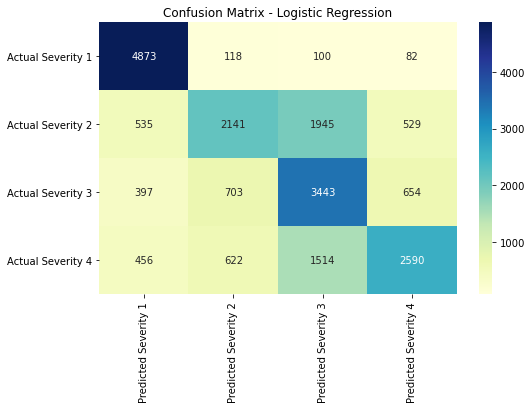

In [41]:
y_pred = lr.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

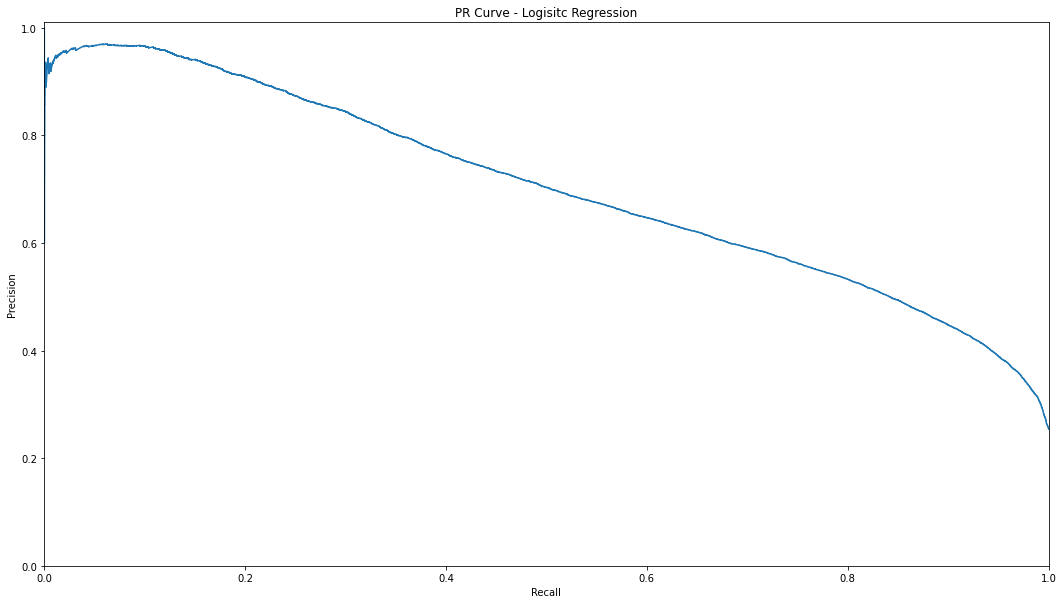

In [42]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = lr.predict_proba(X_validate)

precision["Logistic Regression"], recall["Logistic Regression"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Logistic Regression"], precision["Logistic Regression"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Logisitc Regression")
plt.show()

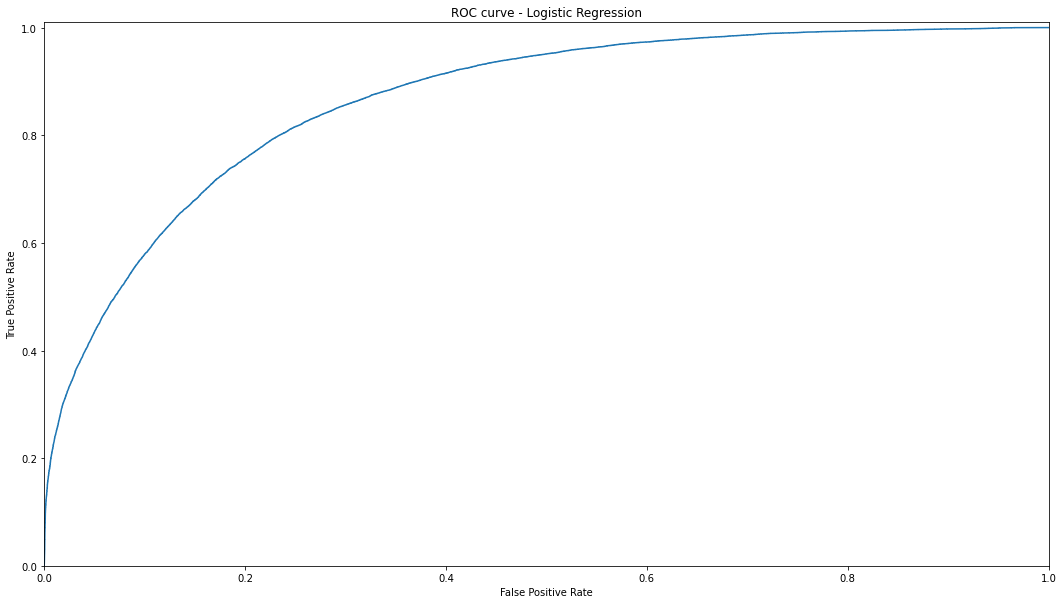

In [43]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Logistic Regression"], tpr["Logistic Regression"], where="post")

plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Support Vector Machine

In [44]:
parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]
svc = svm.SVC(verbose=5, random_state=42)
grid = GridSearchCV(svc, parameters, verbose=5, n_jobs=-1)

sample = X.sample(5_000)
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.5min finished


[LibSVM]

GridSearchCV(estimator=SVC(random_state=42, verbose=5), n_jobs=-1,
             param_grid=[{'C': [0.2, 0.5, 0.8, 1.0],
                          'kernel': ['linear', 'rbf', 'sigmoid']},
                         {'C': [0.2, 0.5, 0.8, 1.0], 'degree': [2, 3, 4],
                          'kernel': ['poly']}],
             verbose=5)

In [45]:
print("Best Params:", grid.best_params_)

Best Params: {'C': 1.0, 'kernel': 'linear'}


In [46]:
sample = X.sample(10_000)
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(8000, 61) (8000,)
(2000, 61) (2000,)


In [47]:
svc = svm.SVC(**grid.best_params_, random_state=42)
svc.fit(X_train, y_train)

print("Train score:", svc.score(X_train, y_train))
print("Validation score:", svc.score(X_validate, y_validate))

Train score: 0.606
Validation score: 0.6095


In [48]:
y_pred = svc.predict(X_validate)

accuracy["SVM"] = accuracy_score(y_validate, y_pred)
f1["SVM"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, svc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.96      0.83      1976
           2       0.59      0.35      0.44      1983
           3       0.48      0.71      0.58      2028
           4       0.65      0.40      0.50      2013

    accuracy                           0.61      8000
   macro avg       0.61      0.61      0.59      8000
weighted avg       0.61      0.61      0.59      8000

              precision    recall  f1-score   support

           1       0.76      0.97      0.85       523
           2       0.62      0.37      0.46       504
           3       0.46      0.70      0.55       489
           4       0.64      0.38      0.48       484

    accuracy                           0.61      2000
   macro avg       0.62      0.60      0.59      2000
weighted avg       0.62      0.61      0.59      2000



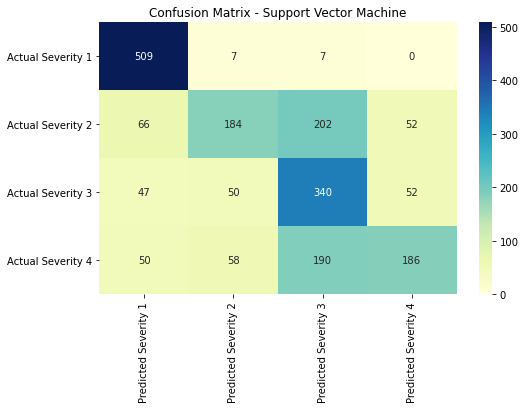

In [49]:
y_pred = svc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

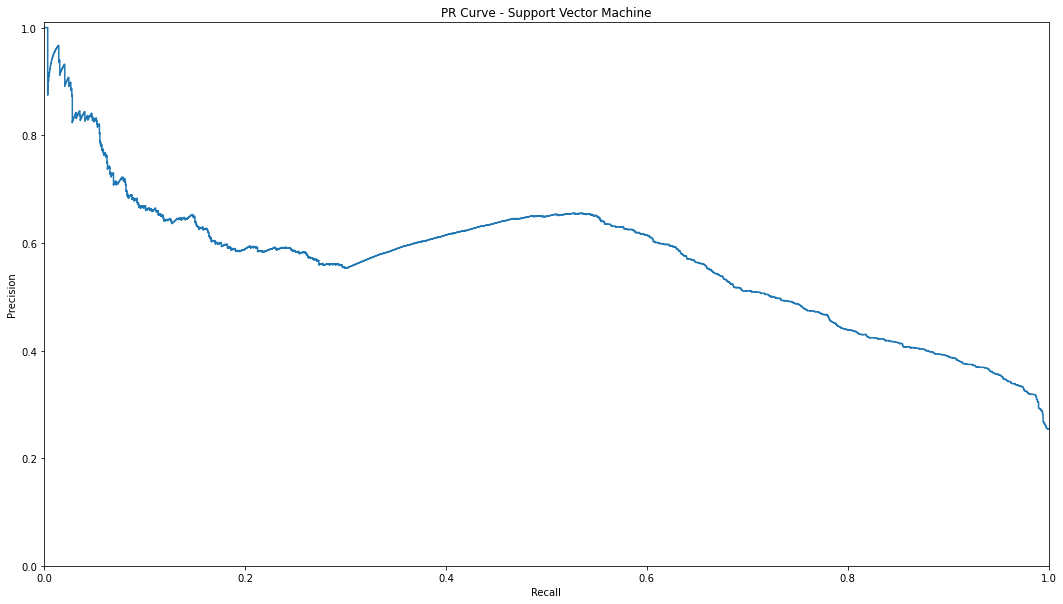

In [50]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = svc.decision_function(X_validate)

precision["SVM"], recall["SVM"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["SVM"], tpr["SVM"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["SVM"], precision["SVM"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Support Vector Machine")
plt.show()

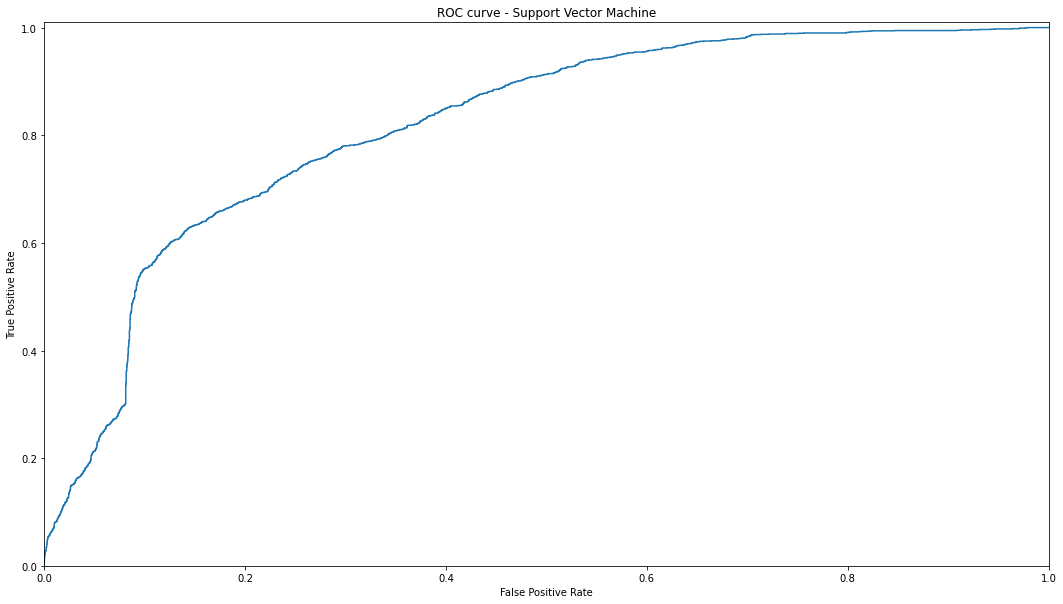

In [51]:
plt.figure(figsize=(18, 10))
plt.step(fpr["SVM"], tpr["SVM"], where="post")

plt.title("ROC curve - Support Vector Machine")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Decision Tree

In [52]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62104, 61) (62104,)
(20702, 61) (20702,)


In [53]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

print("Train score:", dtc.score(X_train, y_train))
print("Validation score:", dtc.score(X_validate, y_validate))

Train score: 1.0
Validation score: 0.7089170128490001


In [54]:
y_pred = dtc.predict(X_validate)

accuracy["Decision Tree"] = accuracy_score(y_validate, y_pred)
f1["Decision Tree"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, dtc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     15559
           2       1.00      1.00      1.00     15371
           3       1.00      1.00      1.00     15493
           4       1.00      1.00      1.00     15681

    accuracy                           1.00     62104
   macro avg       1.00      1.00      1.00     62104
weighted avg       1.00      1.00      1.00     62104

              precision    recall  f1-score   support

           1       0.90      0.92      0.91      5173
           2       0.60      0.58      0.59      5150
           3       0.58      0.58      0.58      5197
           4       0.75      0.75      0.75      5182

    accuracy                           0.71     20702
   macro avg       0.71      0.71      0.71     20702
weighted avg       0.71      0.71      0.71     20702



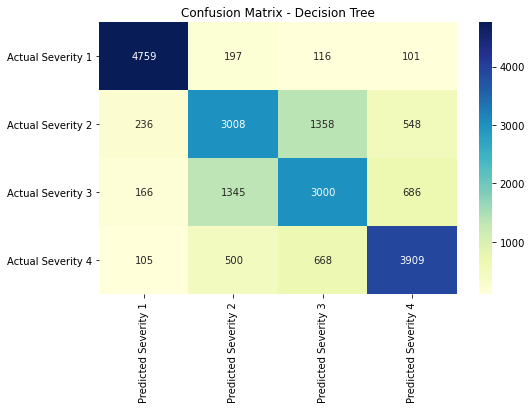

In [55]:
y_pred = dtc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

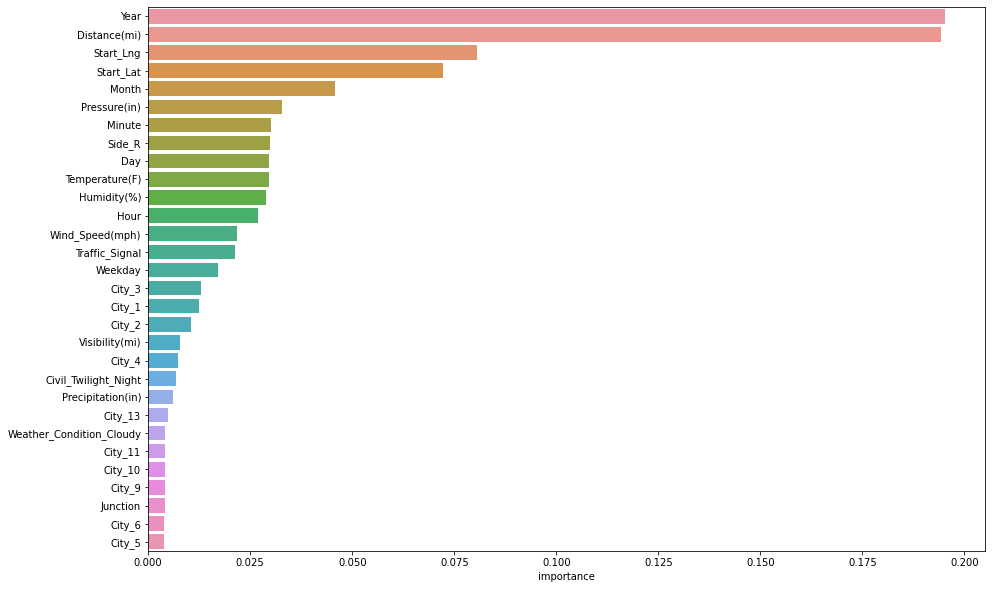

In [56]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = dtc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

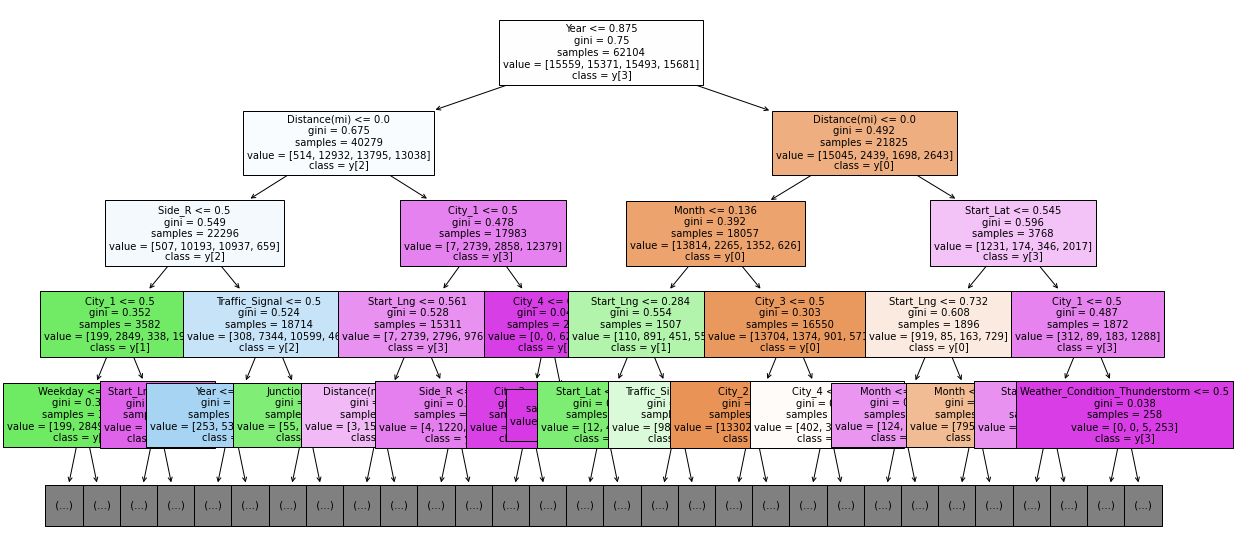

In [57]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train.columns.to_list(), class_names = True, filled=True)
plt.show()

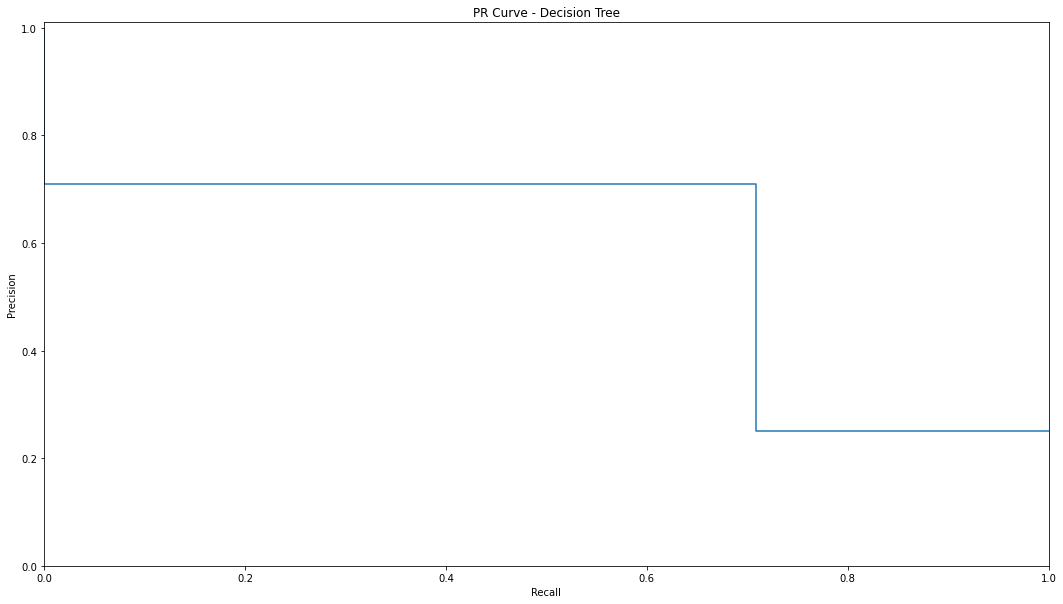

In [58]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = dtc.predict_proba(X_validate)

precision["Decision Tree"], recall["Decision Tree"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Decision Tree"], precision["Decision Tree"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Decision Tree")
plt.show()

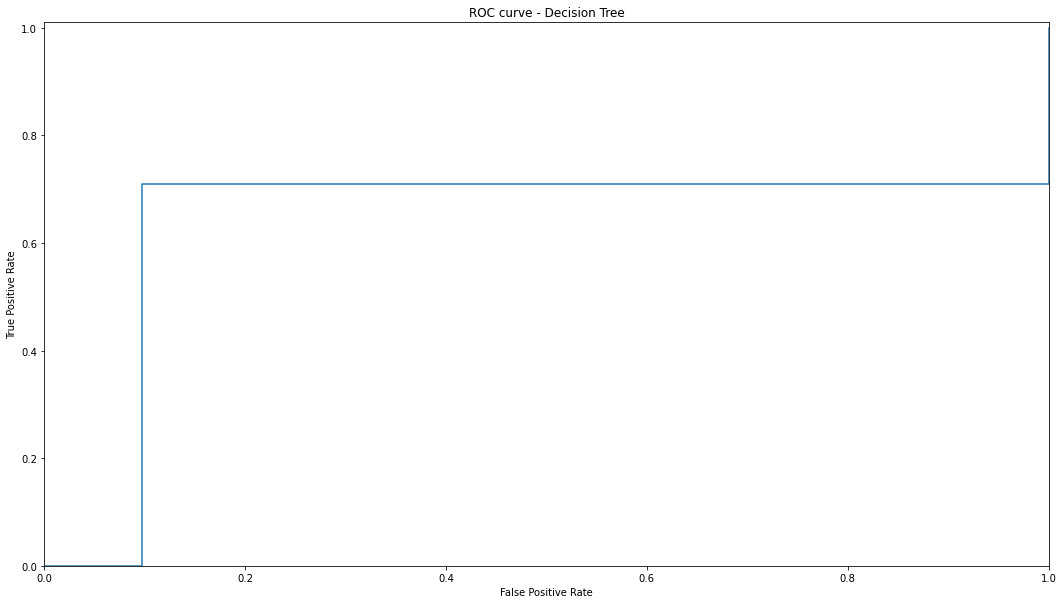

In [59]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Decision Tree"], tpr["Decision Tree"], where="post")

plt.title("ROC curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Random Forest

In [60]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62104, 61) (62104,)
(20702, 61) (20702,)


In [61]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

print("Train score:", rfc.score(X_train, y_train))
print("Validation score:", rfc.score(X_validate, y_validate))

Train score: 1.0
Validation score: 0.7825813931021157


In [62]:
y_pred = rfc.predict(X_validate)

accuracy["Random Forest"] = accuracy_score(y_validate, y_pred)
f1["Random Forest"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, rfc.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     15559
           2       1.00      1.00      1.00     15371
           3       1.00      1.00      1.00     15493
           4       1.00      1.00      1.00     15681

    accuracy                           1.00     62104
   macro avg       1.00      1.00      1.00     62104
weighted avg       1.00      1.00      1.00     62104

              precision    recall  f1-score   support

           1       0.91      0.97      0.93      5173
           2       0.75      0.61      0.67      5150
           3       0.72      0.64      0.68      5197
           4       0.74      0.92      0.82      5182

    accuracy                           0.78     20702
   macro avg       0.78      0.78      0.78     20702
weighted avg       0.78      0.78      0.78     20702



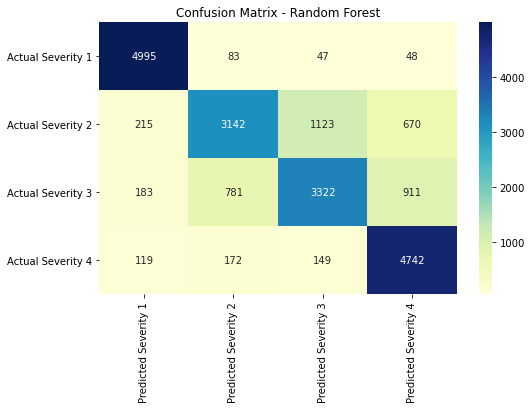

In [63]:
y_pred = rfc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest")
plt.show()

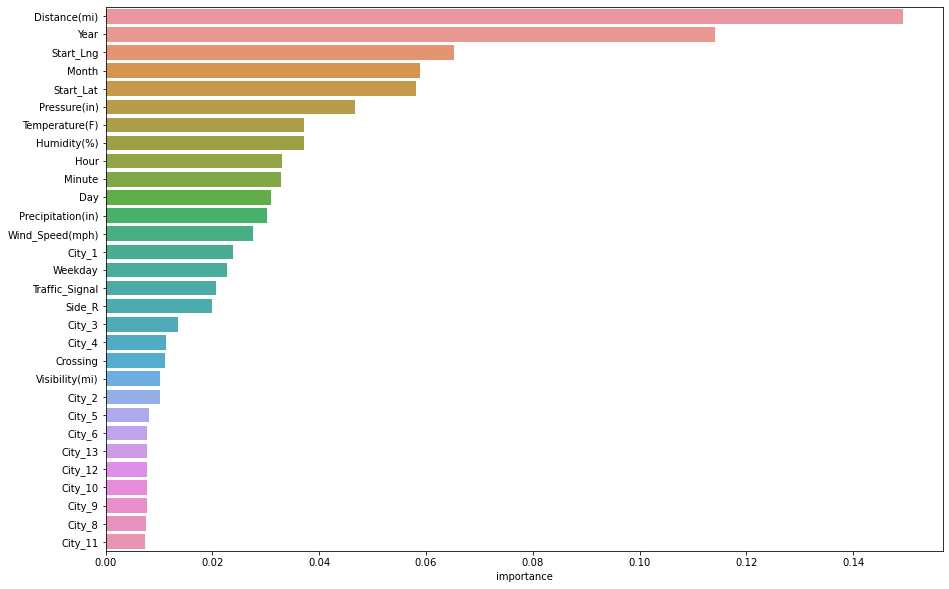

In [64]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

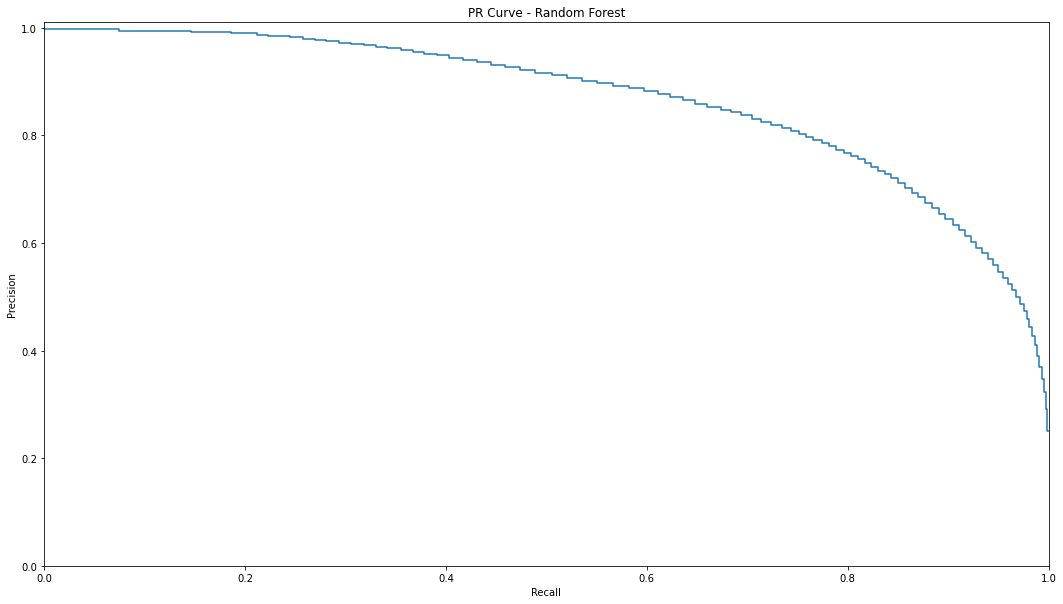

In [65]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_validate)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest")
plt.show()

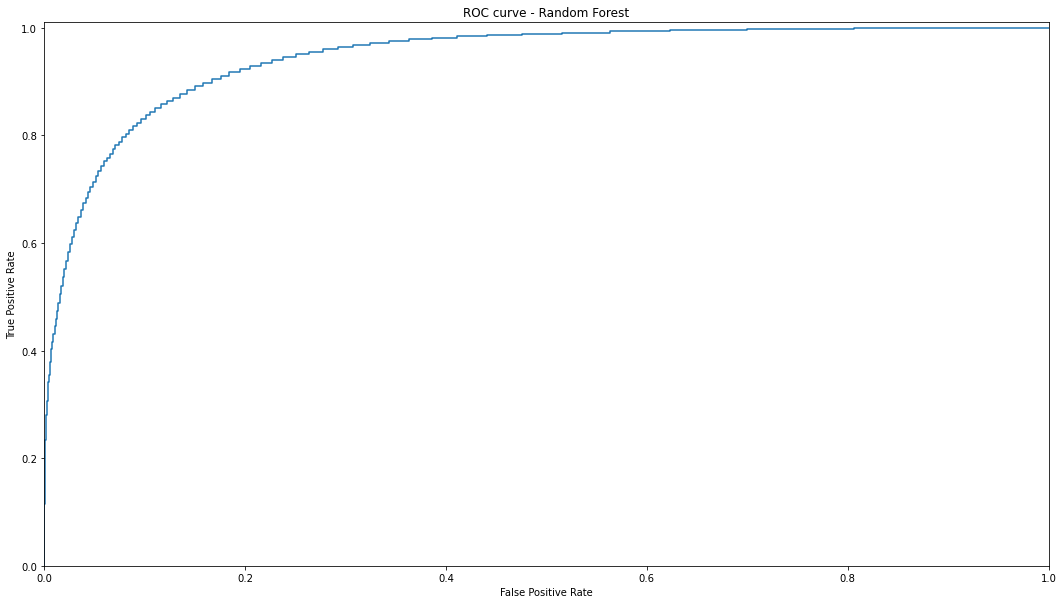

In [66]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")

plt.title("ROC curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Naive Bayes

In [67]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62104, 61) (62104,)
(20702, 61) (20702,)


In [68]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("Train score:", gnb.score(X_train, y_train))
print("Validation score:", gnb.score(X_validate, y_validate))

Train score: 0.5150875950019322
Validation score: 0.5073422857694909


In [69]:
y_pred = gnb.predict(X_validate)

accuracy["Gaussian Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Gaussian Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, gnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.55      0.92      0.69     15559
           2       0.58      0.05      0.09     15371
           3       0.48      0.48      0.48     15493
           4       0.49      0.61      0.54     15681

    accuracy                           0.52     62104
   macro avg       0.52      0.51      0.45     62104
weighted avg       0.52      0.52      0.45     62104

              precision    recall  f1-score   support

           1       0.55      0.92      0.69      5173
           2       0.52      0.04      0.07      5150
           3       0.48      0.46      0.47      5197
           4       0.48      0.60      0.53      5182

    accuracy                           0.51     20702
   macro avg       0.51      0.51      0.44     20702
weighted avg       0.51      0.51      0.44     20702



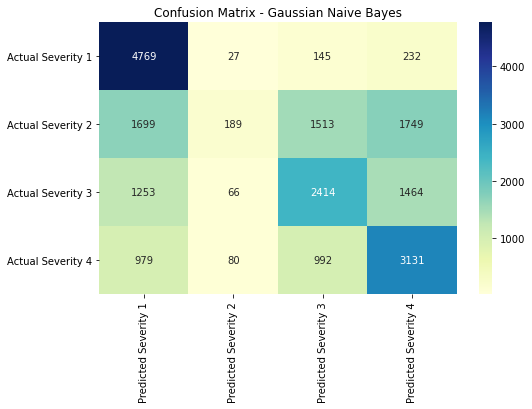

In [70]:
y_pred = gnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

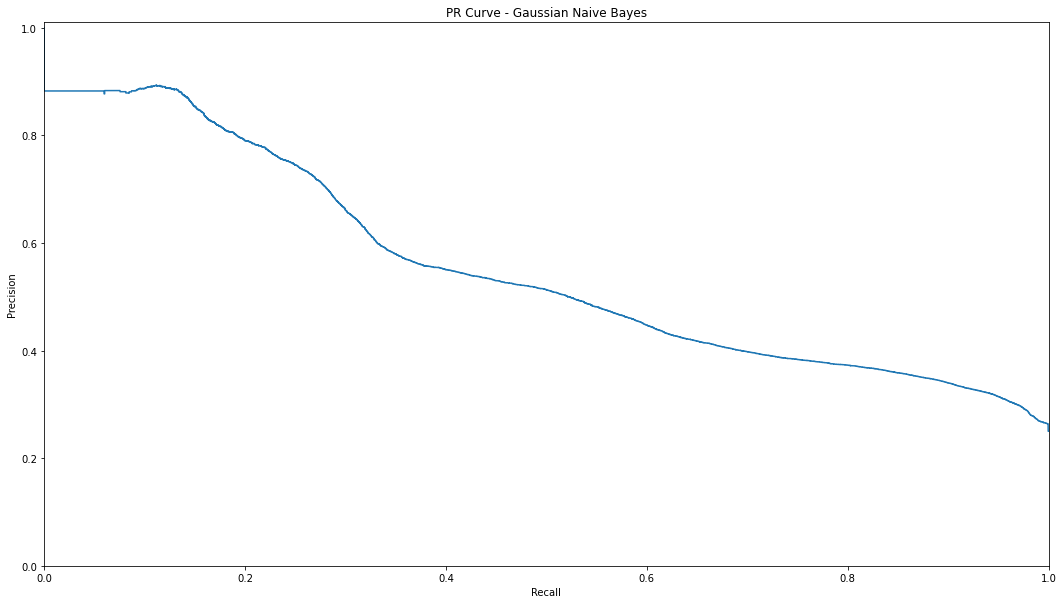

In [71]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = gnb.predict_proba(X_validate)

precision["Gaussian Naive Bayes"], recall["Gaussian Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Gaussian Naive Bayes"], precision["Gaussian Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Gaussian Naive Bayes")
plt.show()

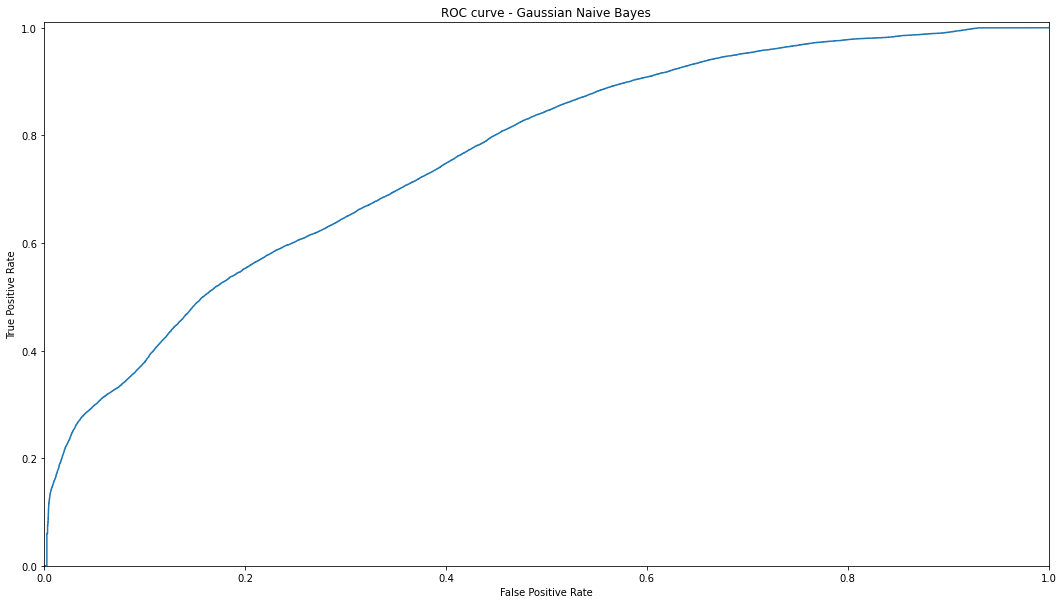

In [72]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], where="post")

plt.title("ROC curve - Gaussian Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [73]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

print("Train score:", mnb.score(X_train, y_train))
print("Validation score:", mnb.score(X_validate, y_validate))

Train score: 0.49283460002576324
Validation score: 0.4920780600908125


In [74]:
y_pred = mnb.predict(X_validate)

accuracy["Multinomial Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Multinomial Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.70      0.65     15559
           2       0.50      0.16      0.24     15371
           3       0.38      0.69      0.49     15493
           4       0.59      0.43      0.49     15681

    accuracy                           0.49     62104
   macro avg       0.52      0.49      0.47     62104
weighted avg       0.52      0.49      0.47     62104

              precision    recall  f1-score   support

           1       0.61      0.71      0.66      5173
           2       0.52      0.16      0.24      5150
           3       0.38      0.68      0.49      5197
           4       0.58      0.42      0.48      5182

    accuracy                           0.49     20702
   macro avg       0.52      0.49      0.47     20702
weighted avg       0.52      0.49      0.47     20702



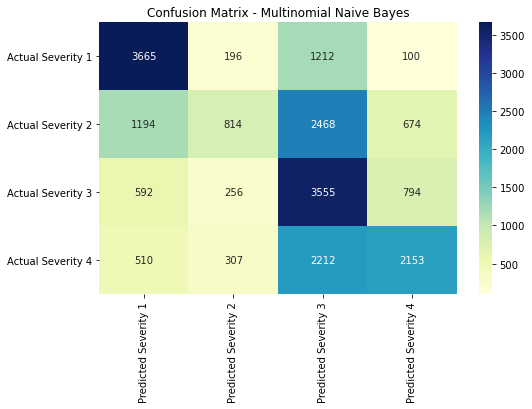

In [75]:
y_pred = mnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

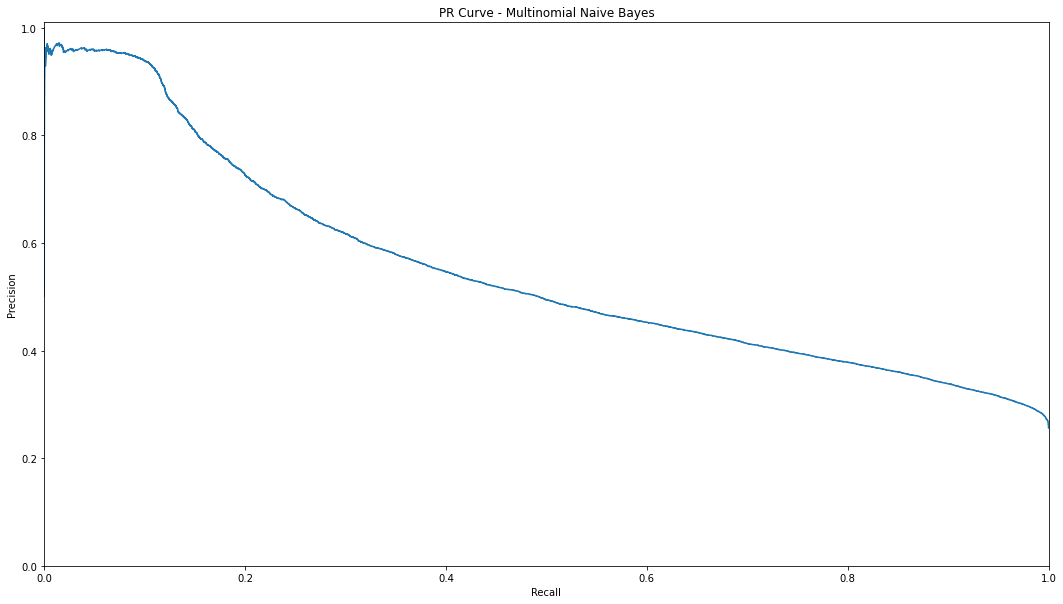

In [76]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = mnb.predict_proba(X_validate)

precision["Multinomial Naive Bayes"], recall["Multinomial Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multinomial Naive Bayes"], precision["Multinomial Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multinomial Naive Bayes")
plt.show()

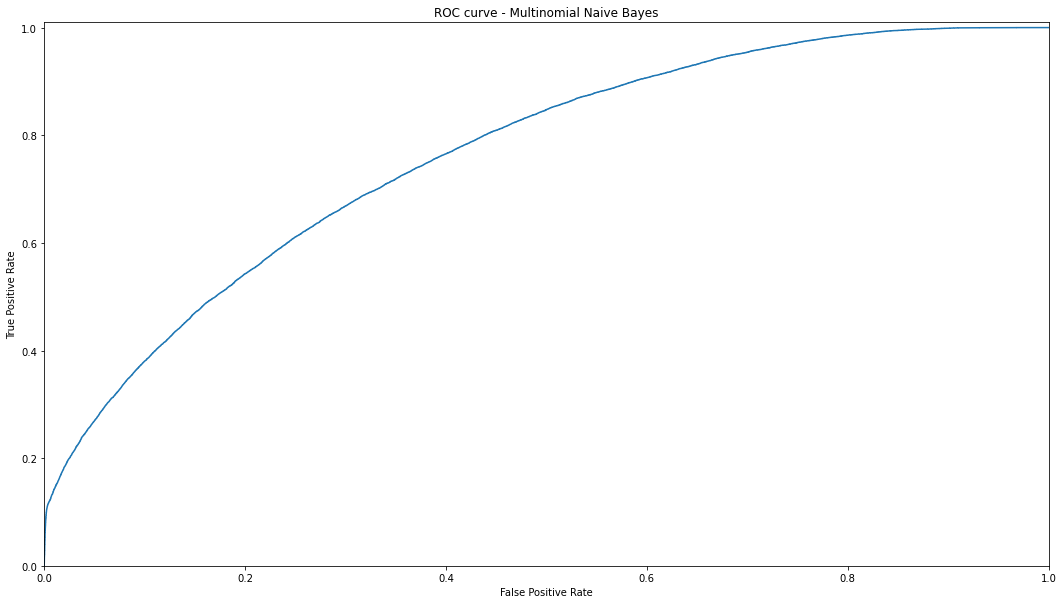

In [77]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], where="post")

plt.title("ROC curve - Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [78]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

print("Train score:", bnb.score(X_train, y_train))
print("Validation score:", bnb.score(X_validate, y_validate))

Train score: 0.6024732706427928
Validation score: 0.599652207516182


In [79]:
y_pred = bnb.predict(X_validate)

accuracy["Bernoulli Naive Bayes"] = accuracy_score(y_validate, y_pred)
f1["Bernoulli Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mnb.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.70      0.65     15559
           2       0.50      0.16      0.24     15371
           3       0.38      0.69      0.49     15493
           4       0.59      0.43      0.49     15681

    accuracy                           0.49     62104
   macro avg       0.52      0.49      0.47     62104
weighted avg       0.52      0.49      0.47     62104

              precision    recall  f1-score   support

           1       0.66      0.74      0.70      5173
           2       0.62      0.29      0.39      5150
           3       0.52      0.55      0.53      5197
           4       0.61      0.82      0.70      5182

    accuracy                           0.60     20702
   macro avg       0.60      0.60      0.58     20702
weighted avg       0.60      0.60      0.58     20702



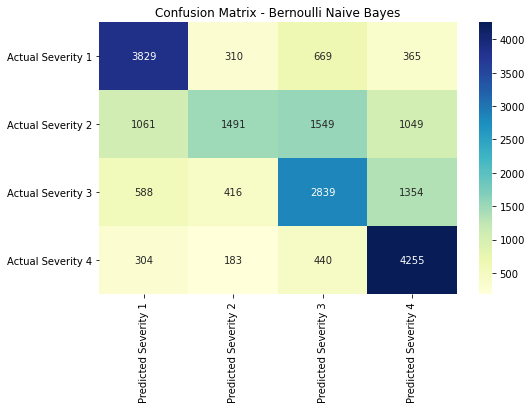

In [80]:
y_pred = bnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.show()

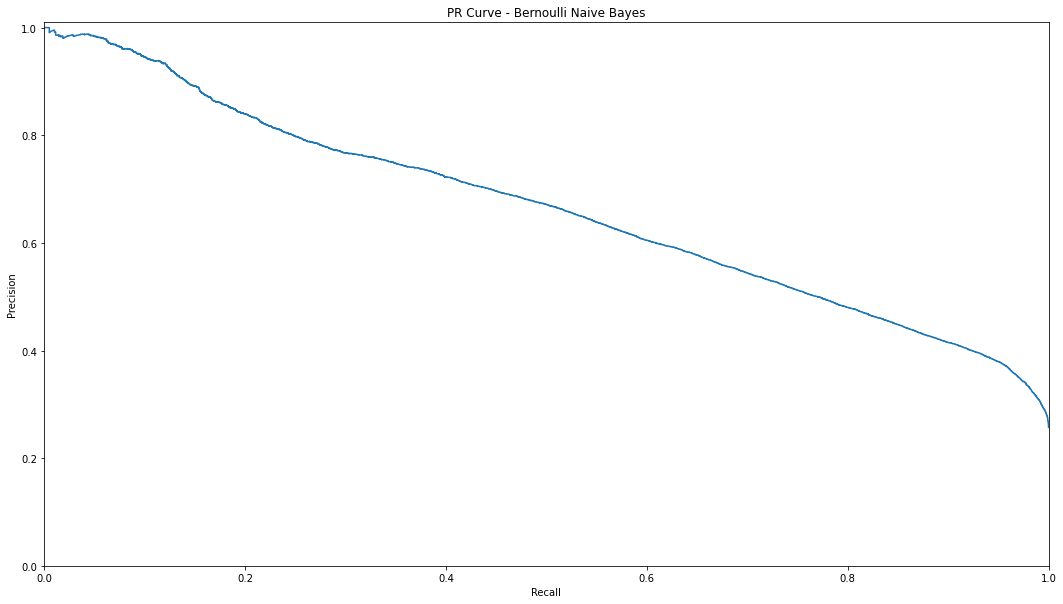

In [81]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = bnb.predict_proba(X_validate)

precision["Bernoulli Naive Bayes"], recall["Bernoulli Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Bernoulli Naive Bayes"], precision["Bernoulli Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Bernoulli Naive Bayes")
plt.show()

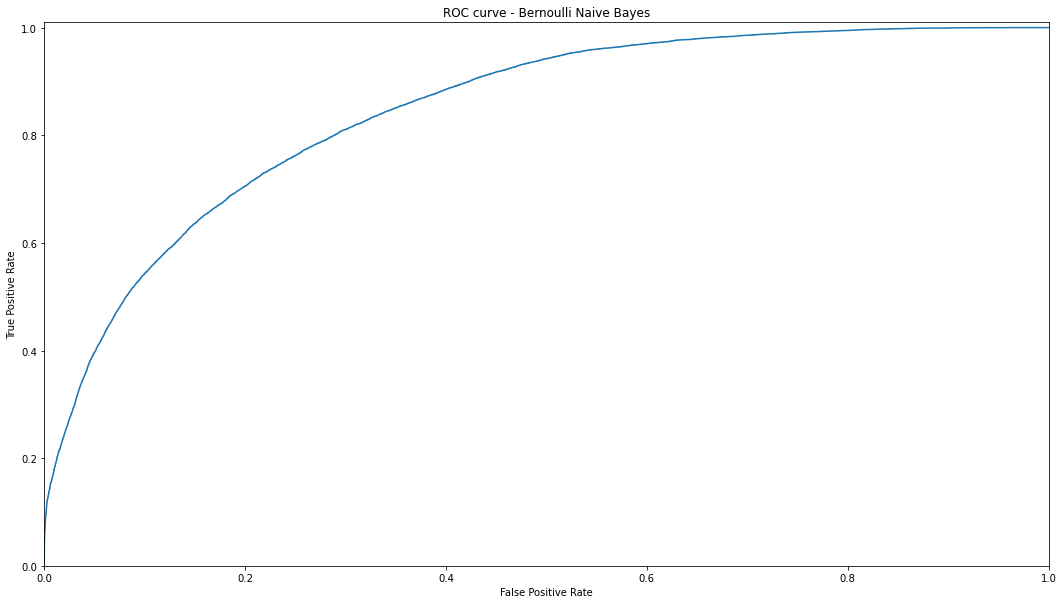

In [82]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], where="post")

plt.title("ROC curve - Bernoulli Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Multi Layer Perceptron

In [83]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(62104, 61) (62104,)
(20702, 61) (20702,)


In [84]:
from warnings import filterwarnings
filterwarnings("ignore")

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, solver="adam", activation="relu", random_state=42, verbose=True)
mlp.fit(X_train, y_train)
print("Train score:", mlp.score(X_train, y_train))
print("Validation score:", mlp.score(X_validate, y_validate))

Iteration 1, loss = 1.06897846
Iteration 2, loss = 0.92596085
Iteration 3, loss = 0.90608525
Iteration 4, loss = 0.89009448
Iteration 5, loss = 0.87665770
Iteration 6, loss = 0.85930712
Iteration 7, loss = 0.84430593
Iteration 8, loss = 0.82939002
Iteration 9, loss = 0.81817634
Iteration 10, loss = 0.80832041
Iteration 11, loss = 0.80001830
Iteration 12, loss = 0.79182404
Iteration 13, loss = 0.78476898
Iteration 14, loss = 0.77614388
Iteration 15, loss = 0.77200886
Iteration 16, loss = 0.76604763
Iteration 17, loss = 0.76075234
Iteration 18, loss = 0.75371334
Iteration 19, loss = 0.75117538
Iteration 20, loss = 0.74398422
Iteration 21, loss = 0.74039132
Iteration 22, loss = 0.73546519
Iteration 23, loss = 0.72971778
Iteration 24, loss = 0.72617449
Iteration 25, loss = 0.72175887
Iteration 26, loss = 0.71822632
Iteration 27, loss = 0.71450728
Iteration 28, loss = 0.71185500
Iteration 29, loss = 0.70750178
Iteration 30, loss = 0.70416055
Iteration 31, loss = 0.70143512
Iteration 32, los

In [85]:
y_pred = mlp.predict(X_validate)

accuracy["Multi Layer Perceptron"] = accuracy_score(y_validate, y_pred)
f1["Multi Layer Perceptron"] = f1_score(y_validate, y_pred, average="macro")

print(classification_report(y_train, mlp.predict(X_train)))
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.95      0.92     15559
           2       0.69      0.63      0.65     15371
           3       0.65      0.65      0.65     15493
           4       0.76      0.79      0.78     15681

    accuracy                           0.75     62104
   macro avg       0.75      0.75      0.75     62104
weighted avg       0.75      0.75      0.75     62104

              precision    recall  f1-score   support

           1       0.89      0.93      0.91      5173
           2       0.64      0.60      0.62      5150
           3       0.63      0.61      0.62      5197
           4       0.74      0.77      0.75      5182

    accuracy                           0.73     20702
   macro avg       0.72      0.73      0.73     20702
weighted avg       0.72      0.73      0.73     20702



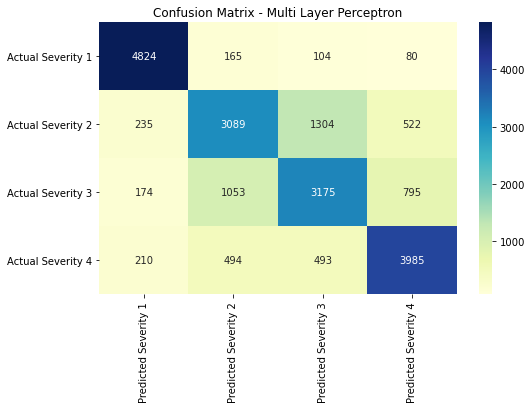

In [86]:
y_pred = mlp.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multi Layer Perceptron")
plt.show()

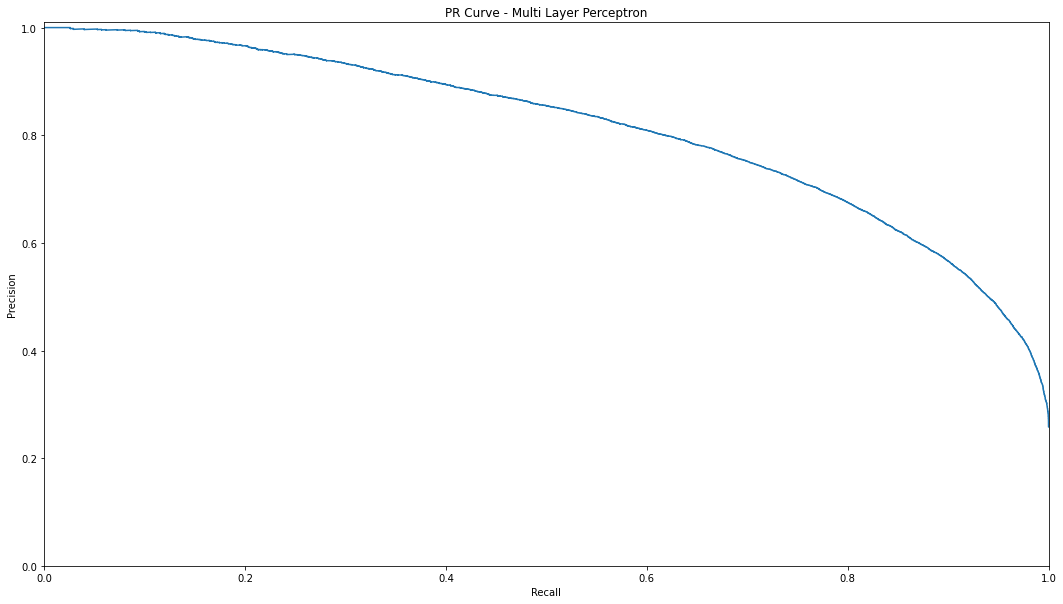

In [87]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = mlp.predict_proba(X_validate)

precision["Multi Layer Perceptron"], recall["Multi Layer Perceptron"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multi Layer Perceptron"], precision["Multi Layer Perceptron"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multi Layer Perceptron")
plt.show()

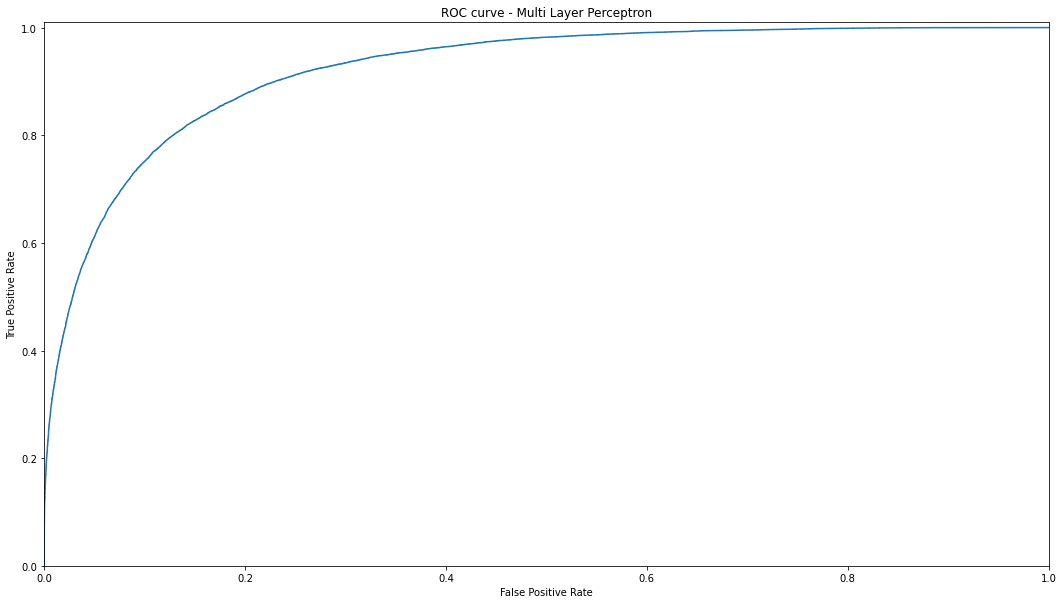

In [88]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multi Layer Perceptron"], tpr["Multi Layer Perceptron"], where="post")

plt.title("ROC curve - Multi Layer Perceptron")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# Results

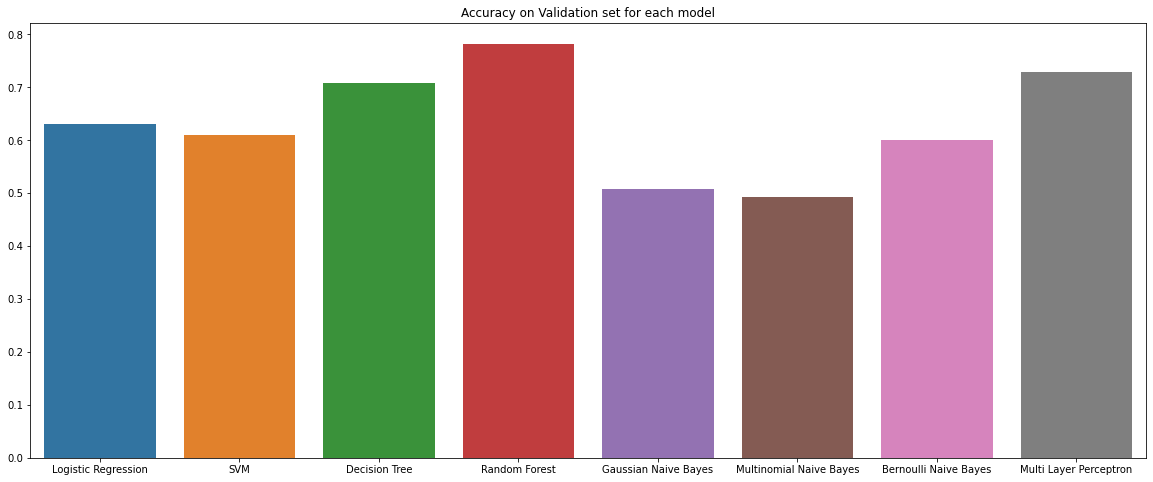

In [89]:
plt.figure(figsize=(20, 8))
plt.title("Accuracy on Validation set for each model")
sns.barplot(list(range(len(accuracy))), list(accuracy.values()))
plt.xticks(range(len(accuracy)), labels=accuracy.keys())
plt.show()

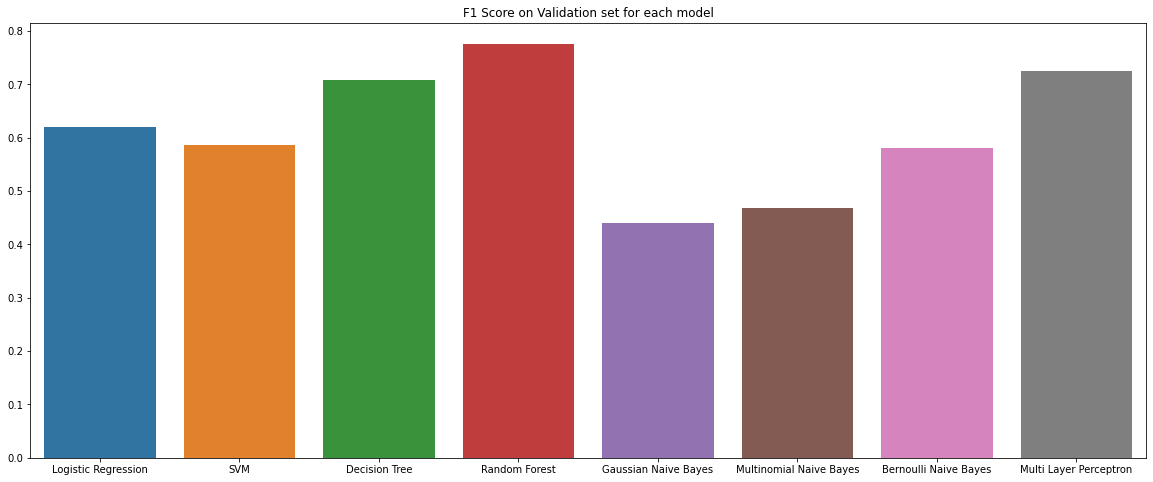

In [90]:
plt.figure(figsize=(20, 8))
plt.title("F1 Score on Validation set for each model")
sns.barplot(list(range(len(f1))), list(f1.values()))
plt.xticks(range(len(f1)), labels=f1.keys())
plt.show()

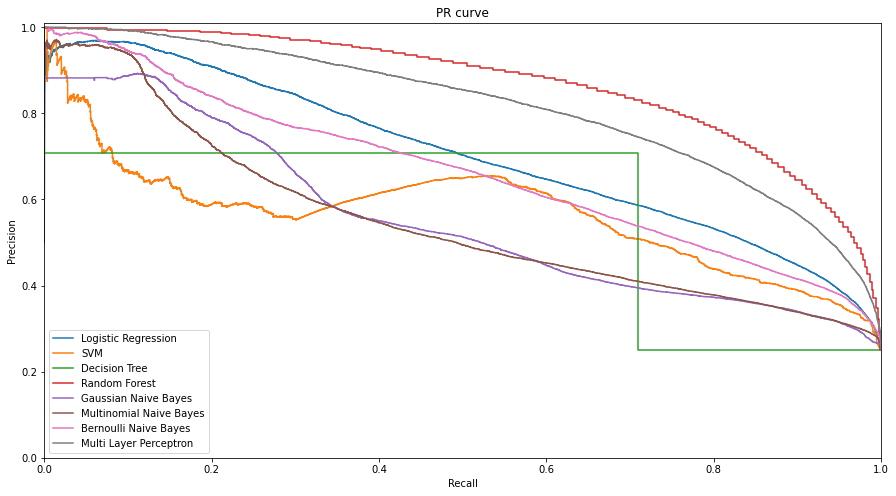

In [91]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.show()

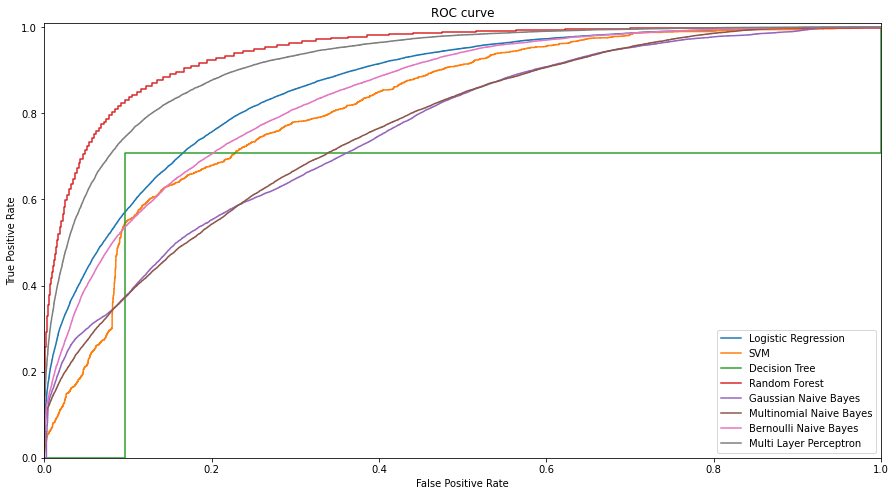

In [92]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           1       0.89      0.97      0.93      5145
           2       0.75      0.60      0.67      5356
           3       0.71      0.65      0.68      5187
           4       0.74      0.91      0.82      5014

    accuracy                           0.78     20702
   macro avg       0.78      0.78      0.77     20702
weighted avg       0.78      0.78      0.77     20702



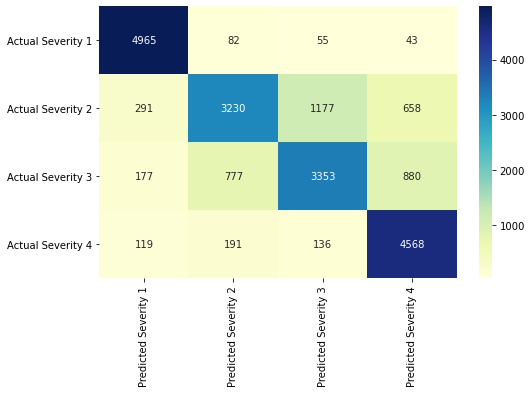

In [93]:
sample = X_test
y_test_sample = sample["Severity"]
X_test_sample = sample.drop("Severity", axis=1)

y_pred = rfc.predict(X_test_sample)

print(classification_report(y_test_sample, y_pred))

confmat = confusion_matrix(y_true=y_test_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.show()